Duration: ~20 minutes

# Hierarchical Forecasting with sktime

Many forecasting problems involve multiple related time series organised
in hierarchical structures.

Examples include:

- Product → Category → Total sales
- Store → Region → Country
- SKU → Department → Company revenue

Forecasts produced independently at each level are often **inconsistent**,
meaning aggregated forecasts do not match higher-level predictions.

`sktime` provides a unified API to:

- represent hierarchical time series
- generate forecasts
- reconcile predictions across hierarchy levels

This tutorial introduces hierarchical forecasting workflows using sktime.

## Learning Objectives

By the end of this tutorial you will:

- Understand hierarchical time series structure
- Apply reconciliation methods in sktime
- Use transformation-based reconciliation API
- Compare reconciliation strategies

#### Tip:
Reconciliation in sktime is implemented as a transformation,
allowing seamless composition with any forecaster.

In [1]:
# Core libraries
import pandas as pd
import matplotlib.pyplot as plt

# Dataset
from tsbook.datasets.retail import SyntheticRetail

# Forecasting
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.reconcile import ReconcilerForecaster

# Hierarchical tools
from sktime.transformations.hierarchical.aggregate import Aggregator
from sktime.transformations.hierarchical.reconcile import (
    BottomUpReconciler,
    TopdownReconciler,
    OptimalReconciler,
)

from sktime.performance_metrics.forecasting import MeanSquaredScaledError

Role:
Loads forecasting + reconciliation APIs used throughout tutorial.

In [2]:
# Load hierarchical retail dataset
dataset = SyntheticRetail("hierarchical")

y_train, X_train, y_test, X_test = dataset.load(
    "y_train", "X_train", "y_test", "X_test"
)

y_train.head()

sales
group_id sku_id date             
-1       20     2020-01-01      0
                2020-01-02      0
                2020-01-03      0
                2020-01-04      0
                2020-01-05      2

Role:
Introduces hierarchical data used for all examples.

## Hierarchical Data Structure

Hierarchical time series in sktime are stored using a **MultiIndex**.

Typical structure:

(level_1, level_2, time)

Each combination represents one individual time series.

In [3]:
# number of individual time series
y_train.index.droplevel(-1).nunique()

31

Role:
Shows how hierarchy levels exist inside dataframe.

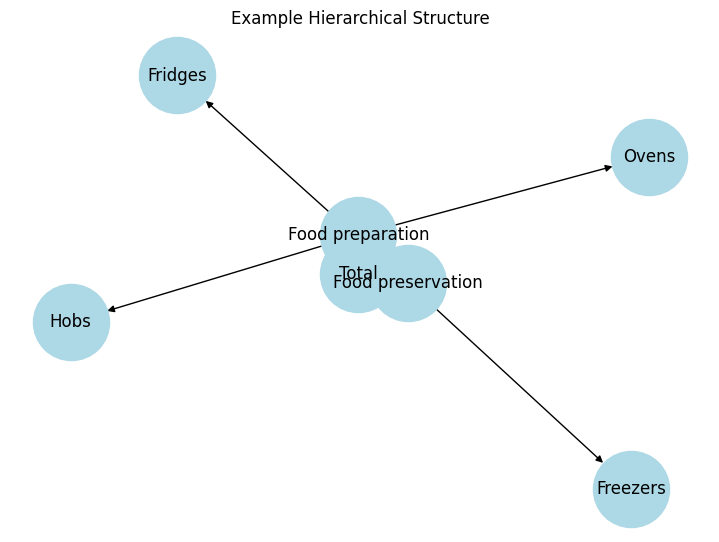

In [4]:
import networkx as nx

G = nx.DiGraph()

G.add_edges_from([
    ("Total", "Food preparation"),
    ("Total", "Food preservation"),
    ("Food preparation", "Hobs"),
    ("Food preparation", "Ovens"),
    ("Food preservation", "Fridges"),
    ("Food preservation", "Freezers"),
])

plt.figure(figsize=(7,5))
nx.draw(
    G,
    nx.spring_layout(G, seed=42),
    with_labels=True,
    node_size=3000,
    node_color="lightblue"
)

plt.title("Example Hierarchical Structure")
plt.show()

Role:
Visual intuition of hierarchy.

In [5]:
# Simple baseline forecaster
forecaster = NaiveForecaster(strategy="last")

forecaster.fit(y_train)

# forecasting horizon
fh = list(range(
    1,
    len(y_test.index.get_level_values(-1).unique()) + 1
))

y_pred = forecaster.predict(fh)

Role:
Creates independent forecasts before reconciliation.

In [6]:
import warnings
# Ignoring the unnecessary warnings .
warnings.filterwarnings('ignore')

# check aggregation mismatch
Aggregator().fit_transform(y_pred) - y_pred

sales
group_id sku_id  date             
-1       20      2024-07-06    0.0
                 2024-07-07    0.0
                 2024-07-08    0.0
                 2024-07-09    0.0
                 2024-07-10    0.0
...                            ...
__total  __total 2024-12-28    0.0
                 2024-12-29    0.0
                 2024-12-30    0.0
                 2024-12-31    0.0
                 2025-01-01    0.0

[5580 rows x 1 columns]

Independent forecasts break hierarchical consistency.

Child forecasts no longer sum to parent forecasts.

In [7]:
bottom_up = BottomUpReconciler() * forecaster

bottom_up.fit(y_train)

y_pred_bottomup = bottom_up.predict(fh)

Role:
Uses transformation-based reconciliation API.

In [8]:
Aggregator().fit_transform(y_pred_bottomup) - y_pred_bottomup

sales
group_id sku_id  date             
-1       20      2024-07-06    0.0
                 2024-07-07    0.0
                 2024-07-08    0.0
                 2024-07-09    0.0
                 2024-07-10    0.0
...                            ...
__total  __total 2024-12-28    0.0
                 2024-12-29    0.0
                 2024-12-30    0.0
                 2024-12-31    0.0
                 2025-01-01    0.0

[5580 rows x 1 columns]

Shows reconciliation success.

In [9]:
top_down = TopdownReconciler() * forecaster

top_down.fit(y_train)

y_pred_topdown = top_down.predict(fh)

Role:
Forecast high level → distribute downward.

In [10]:
optimal = OptimalReconciler("ols") * forecaster

optimal.fit(y_train)

y_pred_optimal = optimal.predict(fh)

### MinT via ReconcilerForecaster

In [11]:
mint = ReconcilerForecaster(
    forecaster=forecaster,
    method="mint_shrink"
)

mint.fit(y_train)

y_pred_mint = mint.predict(fh)

In [12]:
metric = MeanSquaredScaledError(
    multilevel="uniform_average_time"
)

pd.DataFrame({
    "Baseline": metric(y_test, y_pred, y_train=y_train),
    "BottomUp": metric(y_test, y_pred_bottomup, y_train=y_train),
    "TopDown": metric(y_test, y_pred_topdown, y_train=y_train),
    "Optimal": metric(y_test, y_pred_optimal, y_train=y_train),
    "MinT": metric(y_test, y_pred_mint, y_train=y_train),
}, index=["MSSE"])

,Baseline,BottomUp,TopDown,Optimal,MinT
MSSE,39.657047,39.657047,39.657047,39.657047,39.657047


Role:
Practical comparison — documentation style.

## Hierarchical Forecasting in sktime

sktime enables hierarchical forecasting through:

- MultiIndex hierarchical data representation
- Standard forecasting estimators
- ReconcilerForecaster for aggregation consistency

This unified API allows hierarchical forecasting workflows
while remaining compatible with the broader forecasting ecosystem.

## Key Takeaways

- Hierarchical forecasts may be inconsistent when modeled independently.
- sktime provides reconciliation transformers to enforce hierarchy constraints.
- Bottom-up, Top-down and MinT offer different trade-offs.
- Reconciliation can be seamlessly integrated using sktime pipelines.